# UT2 · Colab 2 — Teorema CAP, particiones de red y consistencia (con un “mini Cassandra” de juguete)

## Simulación didáctica: **AP vs CP**, consistencia **fuerte** vs **eventual**, y **quórums** (R/W/N)

Este cuaderno está pensado para entender y explicar **el teorema CAP** y los tipos de **consistencia** sin quedarnos solo en la teoría.

No es un sistema real (no hay sockets ni un clúster de verdad), pero sí imita la **idea clave**:

- Hay varios **nodos** (máquinas/servidores) que guardan copias (**réplicas**) del mismo dato.
- A veces la red se rompe en grupos que **no pueden comunicarse** entre sí (eso es una **partición de red**).
- Cuando pasa esa ruptura, hay que decidir qué priorizar:
  - ¿Preferimos **consistencia** aunque eso implique **rechazar** operaciones? → **CP**
  - ¿Preferimos **disponibilidad** aunque aceptemos diferencias temporales entre copias? → **AP**

---

## Objetivos de aprendizaje

Al terminar este Colab, deberías poder responder:

1. ¿Qué significa la **P** de **CAP** (**Partition tolerance = tolerancia a particiones**) y por qué, en la práctica, **no puedes decidir “no tener P”**?
2. Diferencia entre:
   - **Consistencia fuerte**: “si escribo un valor, cualquier lectura posterior lo ve ya”.
   - **Consistencia eventual**: “si dejamos de escribir, con el tiempo todas las copias acaban siendo iguales”.
3. ¿Qué significa que un sistema sea **CP** o **AP** cuando hay una partición?
4. ¿Qué son los **quórums** y qué significan **N, W y R**?
   - **N (Number of replicas)**: número total de réplicas (copias) del dato.
   - **W (Write quorum)**: cuántas réplicas deben confirmar una **escritura** para considerarla “hecha”.
   - **R (Read quorum)**: a cuántas réplicas consulto en una **lectura**.
   - ¿Por qué importa la regla **R + W > N**?
5. ¿Por qué es difícil evitar duplicados o conflictos cuando hay **consistencia débil** (por ejemplo, eventual)?

---

## Metáfora rápida

Imagina **3 bibliotecas** (nodos) con copias del mismo catálogo (dato clave/valor).  
Si se rompe el puente y quedan incomunicadas (partición de red):

- **CP (Consistency + Partition tolerance)**  
  “Si no puedo hablar con suficientes bibliotecas para asegurar que todas coinciden, prefiero devolver **ERROR** antes que dar un dato dudoso.”

- **AP (Availability + Partition tolerance)**  
  “Sigo atendiendo aunque estemos separados: apunto el cambio aquí y **ya lo reconciliamos después** cuando vuelva la comunicación.”

---

## Qué simulamos en el cuaderno

- **Nodos**: 3 (tres servidores imaginarios).
- **Clave**: `"x"` (el identificador del dato).
- **Valores posibles**: `"A"`, `"B"`, `"C"` (el contenido que puede tomar esa clave).
- **Versión**: un contador (una forma simple de decidir qué copia es “más nueva”).
- **Partición de red**: grupos de nodos que **sí se ven entre sí**, pero **no** pueden hablar con el otro grupo.

⚠️ En sistemas reales hay algoritmos y mecanismos más complejos (por ejemplo **Raft** o **Paxos** para consenso), registros de operaciones (*logs*), relojes, etc.  
Aquí buscamos entender lo importante: el **trade-off** (el “si ganas esto, sacrificas aquello”) cuando la red se parte.


## 0) Preparación
Importamos librerías y dejamos todo listo.

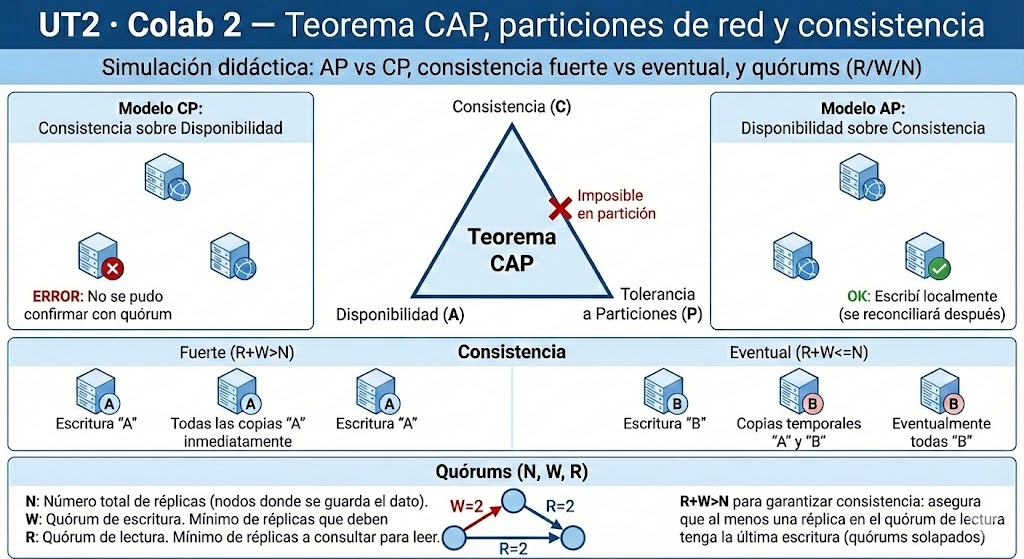

In [1]:
# ---------------------------------------------------------
# 0.1) Importaciones y configuración inicial
# ---------------------------------------------------------
# En esta sección se cargan las librerías que usaremos más adelante
# y se dejan algunos ajustes preparados (como la semilla aleatoria).

# ---- Herramientas para estructuras de datos ----
from dataclasses import dataclass, field
# dataclass: permite definir clases de forma más corta y legible
# field: sirve para configurar atributos con valores por defecto,
#        o comportamientos especiales en dataclasses

# ---- Tipos para documentación y claridad del código ----
from typing import Dict, Tuple, List, Optional, Set
# Estos tipos NO cambian cómo se ejecuta el programa,
# pero ayudan a entender qué se espera en variables y funciones.
# Ejemplos:
# - List[int]  -> lista de enteros
# - Dict[str,int] -> diccionario con claves texto y valores enteros
# - Optional[X] -> puede ser X o None

# ---- Aleatoriedad controlada ----
import random
# random: se usa para generar números o elecciones aleatorias

# ---- Gráficos ----
import matplotlib.pyplot as plt
# pyplot (plt): permite crear gráficos fácilmente

# ---------------------------------------------------------
# Semilla aleatoria (reproducibilidad)
# ---------------------------------------------------------
random.seed(42)
# Fijar la semilla significa que lo "aleatorio" será repetible:
# si ejecutas el programa varias veces, obtendrás los mismos resultados
# aleatorios (muy útil para depurar y comparar resultados).

# Mensaje de confirmación: si esto aparece, significa que todo cargó bien
print("Entorno listo ✅")


Entorno listo ✅


## 1) Modelo mínimo de un nodo con réplicas

Cada **nodo** (servidor) guarda un diccionario con este formato:

- **clave → (valor, versión)**

Es decir, para cada clave (por ejemplo `"x"`) el nodo almacena:
- el **valor** (por ejemplo `"A"`, `"B"`, etc.)
- una **versión** (normalmente un número) que indica qué actualización es más reciente.

Para resolver conflictos cuando dos nodos tienen valores distintos, usamos un criterio simplificado llamado **Last-Write-Wins (LWW)**, que significa **“gana la última escritura”**:

- Se compara la **versión** de cada copia.
- **La copia con la versión más alta es la que se considera correcta** (la “más nueva”).


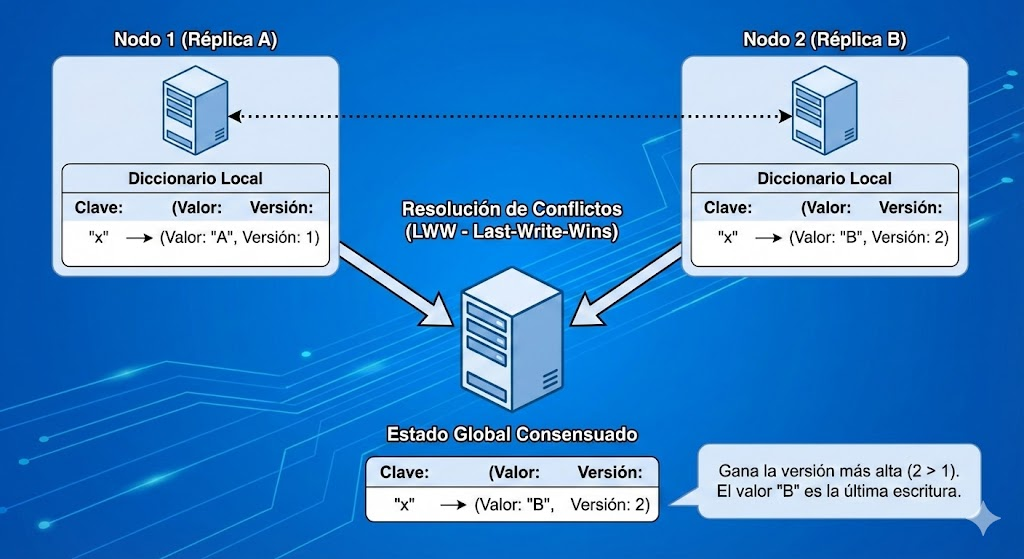

In [2]:
# ---------------------------------------------------------
# 1.1) Registro: valor + versión
# ---------------------------------------------------------
# Un "Registro" representa lo que guardamos para una clave:
# - el dato (valor)
# - un número de versión para saber cuál escritura es la más reciente

@dataclass
class Registro:
    valor: str     # contenido guardado (por ejemplo: "A", "hola", "123")
    version: int   # versión/timestamp lógico: cuanto más grande, más nuevo


# ---------------------------------------------------------
# 1.2) Nodo: almacén local y operaciones básicas
# ---------------------------------------------------------
# Un "Nodo" simula un servidor/replica que guarda datos en un diccionario:
# clave (str) -> Registro(valor, version)

@dataclass
class Nodo:
    nombre: str  # nombre/ID del nodo (por ejemplo: "N0", "N1", ...)
    almacen: Dict[str, Registro] = field(default_factory=dict)
    # default_factory=dict crea un diccionario NUEVO por cada nodo
    # (evita que todos los nodos compartan el mismo diccionario por error)

    def leer(self, clave: str) -> Optional[Registro]:
        """
        Devuelve el Registro asociado a la clave.
        Si la clave no existe, devuelve None.
        """
        return self.almacen.get(clave)
        # .get() es seguro: si la clave no está, devuelve None
        # y evitamos un KeyError

    def escribir(self, clave: str, valor: str, version: int) -> None:
        """
        Guarda (valor, version) en 'clave'.

        Regla usada: LWW (Last-Write-Wins)
        - Si no había nada, escribimos.
        - Si ya había algo, solo reemplazamos si la versión nueva
          es mayor o igual a la actual.
        """
        actual = self.almacen.get(clave)  # registro existente (si lo hay)

        # Si no existe registro previo o el nuevo es más reciente (o igual),
        # lo reemplazamos.
        if actual is None or version >= actual.version:
            self.almacen[clave] = Registro(valor=valor, version=version)

    def __repr__(self) -> str:
        # Representación corta al imprimir el objeto (útil en logs y debugging)
        return f"Nodo({self.nombre})"


## 2) Red con particiones (partición de red)

Para simular una **partición de red** (cuando la red se “parte” y algunos nodos quedan incomunicados), representamos la red como **grupos** de nodos.

La regla es simple:

- Si dos nodos están en el **mismo grupo**, **sí se ven** (pueden comunicarse).
- Si están en **grupos distintos**, **NO se ven** (no pueden enviarse mensajes ni sincronizarse).

Así podemos modelar fácilmente situaciones como:
- Red normal: todos los nodos en un único grupo.
- Red partida: dos o más grupos separados que trabajan “a ciegas” entre sí.


In [3]:
# ---------------------------------------------------------
# 2.1) Construir la partición
# ---------------------------------------------------------
# Una "partición" aquí significa: la red se separa en grupos aislados.
# Los nodos dentro del mismo grupo pueden comunicarse entre sí.
# Los nodos en grupos distintos NO pueden hablar entre ellos.

def crear_particion(grupos: List[Set[int]], num_nodos: int) -> List[int]:
    """
    Crea una estructura que indica a qué grupo pertenece cada nodo.

    Devuelve una lista 'grupo_de' tal que:
      - grupo_de[i] = k  significa que el nodo i está en el grupo k

    Ejemplo:
      grupos = [{0,1}, {2,3}], num_nodos=4
      -> grupo_de podría ser [0,0,1,1]
    """
    # Empezamos con todos los nodos "sin grupo" (-1)
    grupo_de = [-1] * num_nodos

    # Recorremos los grupos y asignamos su número (k) a cada nodo i del grupo
    for k, conjunto in enumerate(grupos):  # k = índice del grupo (0, 1, 2, ...)
        for i in conjunto:                 # i = índice del nodo dentro de ese grupo
            grupo_de[i] = k

    # Si algún nodo no apareció en ningún grupo, lo metemos en un grupo extra
    # (por ejemplo, el grupo con índice len(grupos))
    for i in range(num_nodos):
        if grupo_de[i] == -1:
            grupo_de[i] = len(grupos)

    return grupo_de


# ---------------------------------------------------------
# 2.2) Alcanzabilidad: ¿puede hablar a con b?
# ---------------------------------------------------------
# Dado el resultado de crear_particion, definimos una regla simple:
# dos nodos se comunican SI y SOLO SI están en el mismo grupo.

def puede_hablar(grupo_de: List[int], a: int, b: int) -> bool:
    """
    Devuelve True si los nodos a y b están en el mismo grupo de partición.
    Si están en grupos distintos, devuelve False (no hay comunicación).
    """
    return grupo_de[a] == grupo_de[b]


## 3) Quórums: N, W, R

En sistemas replicados (donde el mismo dato se guarda en varias copias), se usan **quórums** para decidir cuántos nodos deben participar en una lectura o una escritura.

- **N (Number of replicas)**: número total de **réplicas** (copias) del dato.
- **W (Write quorum)**: número de **confirmaciones** necesarias para dar una escritura como válida.  
  Es decir, cuántos nodos deben responder “OK” (ACK, *acknowledgement* = confirmación) tras guardar el dato.
- **R (Read quorum)**: número de réplicas que se consultan al leer.  
  Es decir, a cuántos nodos preguntamos para obtener el valor.

### Regla práctica
**R + W > N**  ⇒ la lectura y la escritura se “solapan” (cuando la red funciona bien).

Esto importa porque, si hay solapamiento, **al menos uno de los nodos leídos debería haber recibido la última escritura**, y así es más probable leer el valor más reciente.


In [4]:
def mayoria(n: int) -> int:
    """
    Calcula el tamaño mínimo de una mayoría (quórum) en un sistema con n nodos.

    ¿Qué significa "mayoría" aquí?
    - Es el número mínimo de nodos que necesitas para asegurar que
      ese grupo es "más de la mitad" del total.
    - Se usa mucho en algoritmos distribuidos (quórum) para decisiones
      como lecturas/escrituras consistentes.

    Fórmula:
      (n // 2) + 1

    Ejemplos:
    - n = 1  -> (1//2)+1 = 0+1 = 1
    - n = 2  -> (2//2)+1 = 1+1 = 2
    - n = 3  -> (3//2)+1 = 1+1 = 2
    - n = 4  -> (4//2)+1 = 2+1 = 3
    - n = 5  -> (5//2)+1 = 2+1 = 3
    """
    return (n // 2) + 1


## 4) Coordinador: escrituras y lecturas en modo CP o AP

En esta simulación hay un **coordinador**: es el nodo (o la lógica) que recibe la petición del cliente y decide a qué réplicas preguntar o escribir.

Dependiendo del modo elegido, el coordinador se comporta de forma distinta:

- **CP (Consistency + Partition tolerance = Consistencia + tolerancia a particiones)**  
  Prioriza la **consistencia**:
  - Si no se consigue el quórum necesario (**W** para escribir o **R** para leer), la operación **falla**.
  - Idea: “prefiero devolver error antes que devolver un dato potencialmente incorrecto”.

- **AP (Availability + Partition tolerance = Disponibilidad + tolerancia a particiones)**  
  Prioriza la **disponibilidad**:
  - Intenta **responder siempre**, aunque no llegue al quórum ideal.
  - Esto se suele lograr configurando un **W bajo** (por ejemplo, aceptar con pocas confirmaciones).
  - Consecuencia: pueden aparecer **diferencias temporales** entre réplicas.

### Reconciliación cuando la red se cura (anti-entropy)
Cuando la partición desaparece y los nodos vuelven a comunicarse, hacemos una reconciliación simple llamada **anti-entropy**:

- Los nodos comparan sus copias.
- Se quedan con la versión más reciente (por ejemplo, usando *Last-Write-Wins*).
- Con el tiempo, todas las réplicas vuelven a **converger** al mismo valor.


In [5]:
# ---------------------------------------------------------
# 4.1) Crear cluster
# ---------------------------------------------------------
# Un "cluster" aquí es simplemente una lista de nodos (réplicas).
# Cada nodo tiene su propio almacén (diccionario clave -> Registro).

def crear_cluster(n: int) -> List[Nodo]:
    """
    Crea n nodos con nombres N0, N1, ..., N(n-1).

    Devuelve:
      - Lista de objetos Nodo ya inicializados.
    """
    return [Nodo(nombre=f"N{i}") for i in range(n)]


# ---------------------------------------------------------
# 4.2) Escritura coordinada
# ---------------------------------------------------------
# Simulamos una escritura donde un "coordinador" intenta enviar la escritura
# a todas las réplicas con las que puede comunicarse (según la partición).
#
# Parámetros relevantes:
# - W: número de ACKs (confirmaciones) mínimo para considerar la escritura "OK"
# - modo:
#   - "CP": si no se alcanza W, se considera fallo (prioriza consistencia)
#   - "AP": intenta aceptar incluso con muy pocos ACKs (prioriza disponibilidad)

def write(cluster: List[Nodo],
          grupo_de: List[int],
          coordinador: int,
          clave: str,
          valor: str,
          version: int,
          W: int,
          modo: str) -> Tuple[bool, List[int]]:
    """
    Intenta replicar una escritura (clave, valor, version) en nodos accesibles.

    Devuelve:
      - ok: True/False según si se considera que la escritura tuvo "éxito"
      - nodos_ack: lista de índices de nodos que aplicaron la escritura (ACK)
    """
    nodos_ack: List[int] = []  # aquí guardamos qué nodos confirmaron (ACK)

    # Recorremos todos los nodos del cluster y escribimos solo en los accesibles
    for i in range(len(cluster)):
        # Solo podemos escribir en i si el coordinador puede comunicarse con i
        if puede_hablar(grupo_de, coordinador, i):
            cluster[i].escribir(clave, valor, version)  # aplica regla LWW del nodo
            nodos_ack.append(i)                         # registramos que i confirmó

    acks = len(nodos_ack)  # número de confirmaciones conseguidas

    # Decidimos si la escritura se acepta o falla según el "modo"
    if modo.upper() == "CP":
        # CP: si no alcanzas W, se considera fallo (aunque se haya escrito en algunos)
        ok = (acks >= W)
    elif modo.upper() == "AP":
        # AP: intenta aceptar con al menos 1 ACK (si W > 1, lo relajamos a 1)
        ok = (acks >= min(W, 1))
    else:
        raise ValueError("modo debe ser 'CP' o 'AP'")

    return ok, nodos_ack


# ---------------------------------------------------------
# 4.3) Lectura coordinada
# ---------------------------------------------------------
# La lectura consulta R réplicas accesibles y devuelve el registro "más nuevo"
# (mayor versión).
#
# Opcionalmente hace "read repair":
# - Si detecta que alguna réplica leída tiene una versión antigua,
#   la actualiza con la más reciente.

def read(cluster: List[Nodo],
         grupo_de: List[int],
         coordinador: int,
         clave: str,
         R: int,
         modo: str,
         read_repair: bool = True) -> Tuple[Optional[Registro], List[int]]:
    """
    Lee 'clave' consultando hasta R réplicas accesibles y devuelve el Registro más nuevo.

    Devuelve:
      - Registro más reciente (o None si no se pudo leer / no existía la clave)
      - Lista de nodos que se intentaron leer (nodos_leidos)
    """
    # Lista de nodos con los que el coordinador puede hablar (misma partición)
    accesibles = [
        i for i in range(len(cluster))
        if puede_hablar(grupo_de, coordinador, i)
    ]

    # Si el coordinador no puede hablar con nadie, la lectura falla
    if not accesibles:
        return None, []

    # Elegimos las primeras R réplicas accesibles (estrategia simple)
    nodos_leidos = accesibles[:R]

    # Guardamos pares (indice_nodo, registro_leido)
    registros: List[Tuple[int, Registro]] = []
    for i in nodos_leidos:
        reg = cluster[i].leer(clave)
        if reg is not None:
            registros.append((i, reg))

    # Si nadie tenía esa clave, devolvemos None pero informamos qué nodos se consultaron
    if not registros:
        return None, nodos_leidos

    # Elegimos el registro con mayor versión (el "más nuevo")
    i_max, reg_max = max(registros, key=lambda t: t[1].version)

    # READ REPAIR:
    # Si leímos versiones antiguas, las actualizamos al valor más reciente.
    # Esto ayuda a "curar" inconsistencias con el tiempo.
    if read_repair:
        for i, reg in registros:
            if reg.version < reg_max.version:
                cluster[i].escribir(clave, reg_max.valor, reg_max.version)

    return reg_max, nodos_leidos


# ---------------------------------------------------------
# 4.4) Reconciliación cuando la red vuelve (anti-entropy)
# ---------------------------------------------------------
# Cuando termina una partición de red, distintas réplicas pueden tener valores distintos.
# Esta función simula una "anti-entropy": busca el valor más nuevo existente y lo propaga a todos.

def reconciliar(cluster: List[Nodo], clave: str) -> None:
    """
    Propaga a todos los nodos el Registro más nuevo que exista para 'clave'.

    Idea:
      1) Mirar qué versiones existen en el cluster
      2) Elegir la más alta (LWW)
      3) Escribirla en todos los nodos
    """
    existentes: List[Registro] = []

    # Recolectamos todos los registros existentes para esa clave
    for nodo in cluster:
        reg = nodo.leer(clave)
        if reg is not None:
            existentes.append(reg)

    # Si nadie tiene la clave, no hay nada que reconciliar
    if not existentes:
        return

    # Elegimos el registro con versión más alta (el "ganador" por LWW)
    reg_max = max(existentes, key=lambda r: r.version)

    # Propagamos el ganador a todos los nodos
    for nodo in cluster:
        nodo.escribir(clave, reg_max.valor, reg_max.version)


## 5) Visualización del estado
Imprimimos el valor+versión de cada nodo para una clave.

In [6]:
def mostrar_estado(cluster: List[Nodo], clave: str) -> None:
    """
    Muestra por pantalla qué guarda cada nodo para una clave concreta.

    Objetivo:
    - Ver rápidamente si las réplicas están sincronizadas o si hay divergencias.
    - Útil para depuración y para entender qué pasó tras particiones/escrituras.

    Parámetros:
    - cluster: lista de nodos (réplicas)
    - clave: la clave que queremos inspeccionar en cada nodo

    Salida:
    - Para cada nodo imprime:
        - "<vacío>" si no existe esa clave en su almacén
        - o "valor=... | version=..." si sí existe
    """
    for nodo in cluster:
        reg = nodo.leer(clave)  # intentamos leer la clave en ese nodo

        if reg is None:
            # El nodo no tiene esa clave guardada
            print(f"{nodo.nombre}: <vacío>")
        else:
            # El nodo sí tiene un Registro: mostramos su valor y su versión
            print(f"{nodo.nombre}: valor={reg.valor} | version={reg.version}")


## 6) Experimento 1 — Sin partición (red sana)

Cuando la red funciona bien y **no hay partición**, los nodos pueden comunicarse sin problemas.

En este caso, **AP** y **CP** suelen comportarse de forma parecida:

- Normalmente se alcanza sin dificultad el quórum (**W** en escrituras y **R** en lecturas).
- Las réplicas se mantienen bastante sincronizadas.
- Por eso, desde fuera, “parece” que ambos modos dan resultados casi iguales.

La diferencia importante es que **la gran separación entre AP y CP aparece cuando la red se parte**:  
ahí es donde cada uno prioriza cosas distintas (disponibilidad vs consistencia).


In [7]:
# ---------------------------------------------------------
# Ejemplo de uso: escritura y lectura en modo CP (consistencia)
# ---------------------------------------------------------
# Vamos a simular un cluster pequeño y hacer:
#  1) Una escritura con quórum de mayoría (W=2 en N=3)
#  2) Una lectura con quórum de mayoría (R=2 en N=3)

N = 3
# Número total de nodos (réplicas) en el cluster: N0, N1, N2

cluster = crear_cluster(N)
# Creamos los nodos del cluster: [Nodo("N0"), Nodo("N1"), Nodo("N2")]

# ---------------------------------------------------------
# Red sin partición: todos los nodos pueden comunicarse
# ---------------------------------------------------------
# crear_particion recibe una lista de grupos (conjuntos de índices de nodos).
# Aquí usamos un único grupo con {0,1,2}, así que todos están conectados.
grupo_de = crear_particion([set(range(N))], num_nodos=N)

# Clave que vamos a guardar/leer en el sistema
clave = "x"

# Versión lógica inicial de la escritura (cuanto mayor, más "reciente")
version = 1

# ---------------------------------------------------------
# Escritura coordinada (modo CP) con quórum de escritura W=mayoría
# ---------------------------------------------------------
# modo="CP" significa:
# - La escritura solo se considera exitosa si alcanza W ACKs reales.
# - Con N=3, mayoría(N)=2, así que necesitamos al menos 2 nodos confirmando.
ok_cp, acks_cp = write(
    cluster,
    grupo_de,
    coordinador=0,          # el nodo N0 actúa como coordinador de la operación
    clave=clave,
    valor="A",              # lo que vamos a escribir en la clave "x"
    version=version,
    W=mayoria(N),           # W=2 (quórum típico)
    modo="CP"
)

# Mostramos si se consideró "OK" y qué nodos confirmaron (ACK)
print("Escritura CP OK?", ok_cp, "| acks:", acks_cp)

# Mostramos el estado real de cada réplica tras la escritura
print("\nEstado:")
mostrar_estado(cluster, clave)

# ---------------------------------------------------------
# Lectura coordinada (modo CP) con quórum de lectura R=mayoría
# ---------------------------------------------------------
# Leemos desde el punto de vista del coordinador N1 (coordinador=1)
# y consultamos R=2 réplicas accesibles.
reg, nodos_leidos = read(
    cluster,
    grupo_de,
    coordinador=1,          # N1 coordina la lectura
    clave=clave,
    R=mayoria(N),           # R=2 (mayoría)
    modo="CP"               # en este código, "modo" no cambia la lógica de read()
)

# Mostramos qué nodos se consultaron y el registro que ganó (por mayor versión)
print("\nLectura CP desde N1 | nodos:", nodos_leidos, "| resultado:", reg)


Escritura CP OK? True | acks: [0, 1, 2]

Estado:
N0: valor=A | version=1
N1: valor=A | version=1
N2: valor=A | version=1

Lectura CP desde N1 | nodos: [0, 1] | resultado: Registro(valor='A', version=1)


## 7) Experimento 2 — Con partición {0,1} / {2}

Ahora simulamos una **partición de red** donde:

- Los nodos **0 y 1** están juntos y **sí pueden comunicarse** entre ellos.
- El nodo **2** queda **aislado** y **no puede comunicarse** con 0 y 1.

Es decir, la red queda separada en dos grupos: **{0,1}** y **{2}**.

### Qué vamos a probar
Hacemos una **escritura** desde el nodo aislado **N2** (nodo 2) y comparamos qué pasa según el modo:

- **Modo CP con W = 2**  
  Como N2 está aislado, no puede conseguir **2 confirmaciones** (ACKs) de escritura.  
  **Resultado esperado:** la escritura **falla** (se rechaza).

- **Modo AP con W = 1**  
  Con solo **1 confirmación** (la del propio N2) ya se acepta la escritura.  
  **Resultado esperado:** la escritura se **acepta localmente**, pero el resto de nodos (0 y 1) no se enteran aún.  
  **Consecuencia:** habrá **divergencia** temporal (copias distintas) hasta que la red se cure y se reconcilie.


In [8]:
# ---------------------------------------------------------
# Escenario con partición de red: el cluster se divide en 2 grupos aislados
# ---------------------------------------------------------
# Tenemos N=3 nodos: {0,1,2}
# Activamos una partición:
#   - Grupo A = {0,1}  (pueden comunicarse entre ellos)
#   - Grupo B = {2}    (N2 queda aislado y solo "se ve" a sí mismo)

grupo_de = crear_particion([{0,1}, {2}], num_nodos=N)

print("Partición activa:", grupo_de)
# Ejemplo esperado de salida: [0, 0, 1]
# (N0 y N1 están en el grupo 0; N2 en el grupo 1)

# ---------------------------------------------------------
# Intento de escritura en modo CP desde el lado aislado (N2)
# ---------------------------------------------------------
# CP (Consistencia) exige cumplir el quórum W.
# Con N=3, mayoria(N)=2, así que W=2.
#
# Pero como N2 está aislado, solo puede escribir en sí mismo -> acks=1.
# Resultado: debería FALLAR (ok=False), aunque N2 haya aplicado el cambio localmente.
ok_cp2, acks_cp2 = write(
    cluster,
    grupo_de,
    coordinador=2,          # N2 coordina la operación desde el grupo aislado
    clave=clave,
    valor="B",              # intenta escribir "B"
    version=2,              # versión más nueva que la anterior
    W=mayoria(N),           # W=2 (mayoría)
    modo="CP"
)

print("\nEscritura CP desde N2 (W=2) OK?", ok_cp2, "| acks:", acks_cp2)

print("\nEstado tras intento CP:")
# Aquí es importante: aunque "ok" sea False, puede que N2 haya escrito localmente
# (depende de la implementación, y en tu write() sí escribe en accesibles).
mostrar_estado(cluster, clave)

# ---------------------------------------------------------
# Intento de escritura en modo AP desde N2
# ---------------------------------------------------------
# AP (Disponibilidad) intenta aceptar operaciones incluso durante particiones.
# Aquí pedimos W=1 para que baste con que N2 se confirme a sí mismo.
#
# Como N2 puede al menos hablar consigo mismo -> acks=1 -> ok=True
ok_ap2, acks_ap2 = write(
    cluster,
    grupo_de,
    coordinador=2,
    clave=clave,
    valor="B",
    version=2,
    W=1,                   # solo pedimos 1 ACK
    modo="AP"
)

print("\nEscritura AP desde N2 (W=1) OK?", ok_ap2, "| acks:", acks_ap2)

print("\nEstado tras AP:")
# Esperable: N2 tiene "B" v2, mientras que N0/N1 pueden seguir con "A" v1
# (divergencia temporal por la partición).
mostrar_estado(cluster, clave)

# ---------------------------------------------------------
# Lecturas desde ambos lados de la partición
# ---------------------------------------------------------
# Leemos con R=1 en cada lado (modo AP).
# - Desde N0 (grupo {0,1}): solo puede consultar a {0,1} -> verá lo que tengan ellos
# - Desde N2 (grupo {2}): solo puede consultarse a sí mismo -> verá su propio valor
reg_01, nodos_01 = read(cluster, grupo_de, coordinador=0, clave=clave, R=1, modo="AP")
reg_2, nodos_2   = read(cluster, grupo_de, coordinador=2, clave=clave, R=1, modo="AP")

print("\nLectura desde N0 (lado {0,1}) |", reg_01)
print("Lectura desde N2 (lado {2})     |", reg_2)
# Resultado típico del experimento:
# - Lado {0,1}: valor="A", version=1
# - Lado {2}:   valor="B", version=2
#
# Esto ilustra el trade-off: AP mantiene disponibilidad, pero puede haber lecturas diferentes
# en cada partición hasta que se reconcilie la red.


Partición activa: [0, 0, 1]

Escritura CP desde N2 (W=2) OK? False | acks: [2]

Estado tras intento CP:
N0: valor=A | version=1
N1: valor=A | version=1
N2: valor=B | version=2

Escritura AP desde N2 (W=1) OK? True | acks: [2]

Estado tras AP:
N0: valor=A | version=1
N1: valor=A | version=1
N2: valor=B | version=2

Lectura desde N0 (lado {0,1}) | Registro(valor='A', version=1)
Lectura desde N2 (lado {2})     | Registro(valor='B', version=2)


### Curamos la red y reconciliamos

Cuando **arreglamos la red** (la partición desaparece y los nodos vuelven a comunicarse), hacemos una **reconciliación** entre réplicas.

En **consistencia eventual**, esto significa que:

- Aunque durante la partición cada grupo pudo guardar valores distintos,
- al recuperar la comunicación, los nodos comparan sus datos (por ejemplo, por versión),
- y poco a poco todos acaban con **la misma copia**.

En resumen: con consistencia eventual, **si dejamos de escribir y la red vuelve a estar bien, el sistema termina convergiendo** (todas las réplicas acaban iguales).


In [9]:
# ---------------------------------------------------------
# Fin de la partición: la red "se cura" y todos vuelven a conectarse
# ---------------------------------------------------------
# Volvemos a una configuración con un único grupo {0,1,2},
# es decir, cualquier nodo puede comunicarse con cualquier otro.

grupo_de = crear_particion([set(range(N))], num_nodos=N)

# ---------------------------------------------------------
# Reconciliación (anti-entropy): hacemos que todas las réplicas converjan
# ---------------------------------------------------------
# Durante la partición, distintos nodos pudieron quedar con valores diferentes.
# reconciliar() busca el Registro más nuevo (mayor versión) existente en el cluster
# y lo propaga a todos los nodos, usando la regla LWW.

reconciliar(cluster, clave)

# ---------------------------------------------------------
# Verificación: mostramos el estado final de cada nodo
# ---------------------------------------------------------
print("Estado tras reconciliación:")
mostrar_estado(cluster, clave)

# Resultado esperado:
# - Todos los nodos deberían mostrar el mismo valor para 'clave'
# - Normalmente el que tenga la versión más alta (por ejemplo "B" versión 2)


Estado tras reconciliación:
N0: valor=B | version=2
N1: valor=B | version=2
N2: valor=B | version=2


## 8) Quórums: limitaciones durante una partición

Los **quórums** ayudan cuando la red está sana, pero durante una **partición de red** tienen límites claros.

Aunque configures una lectura con **R = 2** (consultar 2 réplicas), si estás en un grupo que **no puede ver** al otro lado de la partición:

- Solo podrás leer de los nodos que están **en tu mismo grupo**.
- No podrás preguntar a las réplicas del otro grupo, porque **no hay comunicación**.
- Por tanto, puedes quedarte leyendo un valor **antiguo** aunque “en el otro lado” exista una versión más nueva.

En resumen: con partición, **R grande no garantiza leer lo más reciente** si las réplicas con el dato nuevo están aisladas.


In [10]:
# ---------------------------------------------------------
# Reset y preparación del escenario
# ---------------------------------------------------------
# Reiniciamos el cluster para empezar “desde cero” y evitar que quede
# información de experimentos anteriores.

cluster = crear_cluster(N)
# Creamos N nodos nuevos (N0..N2), todos con almacén vacío.

grupo_de = crear_particion([set(range(N))], num_nodos=N)
# Red normal (sin partición): todos conectados en un único grupo {0,1,2}.

# Escribimos "A" versión 1 usando AP y W=1:
# - En AP con W=1 basta con que al menos una réplica accesible confirme.
# - Como aquí todos están conectados, la escritura se propaga a todos los nodos accesibles
#   (en esta implementación, a todos).
write(
    cluster,
    grupo_de,
    coordinador=0,
    clave=clave,
    valor="A",
    version=1,
    W=1,
    modo="AP"
)

# ---------------------------------------------------------
# Activamos partición y escribimos en el lado aislado
# ---------------------------------------------------------
# Ahora partimos la red en:
#   - Grupo {0,1} (pueden hablar entre ellos)
#   - Grupo {2}   (N2 aislado)
grupo_de = crear_particion([{0,1}, {2}], num_nodos=N)

# Desde el lado aislado (N2) escribimos "B" versión 2 con AP y W=1:
# - N2 solo puede escribir en sí mismo, pero como W=1, se acepta.
# - Resultado: N0 y N1 pueden seguir con "A" v1, mientras N2 tiene "B" v2.
write(
    cluster,
    grupo_de,
    coordinador=2,
    clave=clave,
    valor="B",
    version=2,
    W=1,
    modo="AP"
)

print("Estado con partición:")
# Aquí normalmente veremos divergencia:
# - N0: A v1
# - N1: A v1
# - N2: B v2
mostrar_estado(cluster, clave)

# ---------------------------------------------------------
# Lectura desde N0 con R=1
# ---------------------------------------------------------
# R indica cuántas réplicas consultamos para responder la lectura.
# Con la partición activa y coordinador=0, N0 solo puede hablar con {0,1}.
#
# R=1:
# - Solo consultamos 1 nodo accesible (normalmente N0).
# - Es muy probable que devuelva "A" v1 (porque en {0,1} está la versión vieja).
reg_r1, nodos_r1 = read(
    cluster,
    grupo_de,
    coordinador=0,
    clave=clave,
    R=1,
    modo="AP"
)

print("\nLectura desde N0 con R=1 | nodos:", nodos_r1, "|", reg_r1)

# ---------------------------------------------------------
# Lectura desde N0 con R=2
# ---------------------------------------------------------
# R=2:
# - Consultamos 2 réplicas accesibles (normalmente N0 y N1).
# - Como ambas suelen tener "A" v1, el resultado seguirá siendo "A" v1.
# - Importante: aunque aumentes R, si la versión nueva está en un grupo aislado
#   (N2), no la podrás ver mientras dure la partición.
reg_r2, nodos_r2 = read(
    cluster,
    grupo_de,
    coordinador=0,
    clave=clave,
    R=2,
    modo="AP"
)

print("Lectura desde N0 con R=2 | nodos:", nodos_r2, "|", reg_r2)

# Conclusión del experimento:
# - Subir R mejora la probabilidad de leer el valor más reciente SOLO si ese valor
#   está en alguna de las réplicas accesibles desde el coordinador.
# - Con partición de red, R no puede “saltar” al otro lado.


Estado con partición:
N0: valor=A | version=1
N1: valor=A | version=1
N2: valor=B | version=2

Lectura desde N0 con R=1 | nodos: [0] | Registro(valor='A', version=1)
Lectura desde N0 con R=2 | nodos: [0, 1] | Registro(valor='A', version=1)


### Lectura CP “estricta” (fallar si no hay suficientes réplicas)

Esta parte simula una lectura en modo **CP (Consistency + Partition tolerance = Consistencia + tolerancia a particiones)** de forma **estricta**.

La idea es:

- Para mantener **consistencia**, no te vale con “leer cualquier cosa”.
- Quieres cumplir el quórum de lectura **R** (por ejemplo, una **mayoría** de réplicas).
- Si por culpa de una partición no puedes contactar con suficientes nodos para llegar a **R**, entonces:
  - **la lectura falla** (devuelves error).

En resumen: en CP, si no puedes leer con las garantías necesarias (cumpliendo **R**), **prefieres fallar antes que devolver un dato potencialmente incorrecto o desactualizado**.


In [11]:
def read_cp_estricto(
    cluster: List[Nodo],
    grupo_de: List[int],
    coordinador: int,
    clave: str,
    R: int
):
    """
    Lectura "CP estricta" (quórum estricto):

    Idea:
    - En CP, si dices que necesitas leer de R réplicas, entonces
      si no puedes contactar con al menos R réplicas accesibles,
      la lectura debe FALLAR (para no sacrificar consistencia).
    - Esto simula el comportamiento típico de un sistema CP: ante partición,
      prefiere no responder antes que responder con información incompleta.

    Devuelve:
    - (None, accesibles) si no se puede cumplir R
    - (registro, nodos_leidos) si sí se puede cumplir R (usando read normal)
    """

    # 1) Encontramos qué nodos están accesibles desde el coordinador
    #    (mismo grupo de partición)
    accesibles = [
        i for i in range(len(cluster))
        if puede_hablar(grupo_de, coordinador, i)
    ]

    # 2) Si no hay suficientes accesibles como para cumplir R, fallamos
    if len(accesibles) < R:
        # devolvemos None y la lista de accesibles para que el usuario vea el motivo
        return None, accesibles

    # 3) Si sí hay suficientes, hacemos una lectura normal consultando R réplicas
    return read(cluster, grupo_de, coordinador, clave, R, modo="CP")


# ---------------------------------------------------------
# Prueba con partición activa
# ---------------------------------------------------------
# Mantenemos la red partida en dos grupos:
#   - {0,1} conectados entre sí
#   - {2} aislado
grupo_de = crear_particion([{0,1}, {2}], num_nodos=N)

# Intentamos leer desde N2 con R=2 (queremos 2 réplicas)
# Pero desde N2 solo es accesible el propio nodo 2 -> accesibles = [2]
# Entonces, como len([2]) = 1 < 2, la lectura CP estricta falla y devuelve None.
reg_cp, acc = read_cp_estricto(
    cluster,
    grupo_de,
    coordinador=2,
    clave=clave,
    R=2
)

print("Accesibles desde N2:", acc)
print("Lectura CP estricta (R=2) desde N2 ->", reg_cp)


Accesibles desde N2: [2]
Lectura CP estricta (R=2) desde N2 -> None


## 9) Ejercicios
1. Cambia N=5 y particiona {0,1} / {2,3,4}. ¿Dónde está la mayoría?
2. Prueba W=3, R=3 con N=5: ¿qué pasa durante partición?
3. Simula dos escrituras concurrentes en lados distintos: ¿cómo “gana” una (LWW)?
4. Discute: ¿dónde prefieres CP (config) y dónde AP (métricas/logs)?

---

### Ejercicio 9.1
    Cambiar N=5 y particionar {0,1} / {2,3,4} Dónde está la mayoría?

In [14]:
N = 5
cluster = crear_cluster(N)

grupo_A = {0, 1}
grupo_B = {2, 3, 4}

# Creamos la partición correctamente
grupo_de = crear_particion([grupo_A, grupo_B], num_nodos=N)

print("N =", N)
print("Partición:", grupo_A, "/", grupo_B)
print("Mayoría (⌊N/2⌋ + 1) =", mayoria(N))
print("Tamaño lado A =", len(grupo_A))
print("Tamaño lado B =", len(grupo_B))

N = 5
Partición: {0, 1} / {2, 3, 4}
Mayoría (⌊N/2⌋ + 1) = 3
Tamaño lado A = 2
Tamaño lado B = 3


Con N = 5, la mayoría se calcula como ⌊N/2⌋ + 1 = 3 nodos.
En la partición {0,1} / {2,3,4}, el grupo {2,3,4} tiene 3 nodos, por lo que contiene la mayoría.
El grupo {0,1} solo tiene 2 nodos y no puede alcanzar quórum de mayoría.
Esto es importante porque cualquier operación que requiera mayoría (lecturas o escrituras en modo CP) solo podrá completarse desde el lado que contiene la mayoría.

---
Imaginemos que tenemos un hotel, con una central de reservas, y está replicada en 5 servidores. Si 2 servidores quedan aislados (lado A), quedan 3 servidores conectados (lado B). El lado con 3 servidores puede decidir si hay habitaciones o si una reserva es válida, mientras que el lado A no puede asegurar el global. Antes de hacer CP o AP necesito saber quién tiene mayoría. Sin ella no puedo garantizar nada oficial.

---

### Ejercicio 9.2
    Prueba W=3, R=3 con N=5: ¿qué pasa durante partición?

In [24]:
N = 5
W = 3
R = 3
cluster = crear_cluster(N)

grupo_A = {0, 1}
grupo_B = {2, 3, 4}
grupo_de = crear_particion([grupo_A, grupo_B], num_nodos=N)

clave = "x"
print("=== Escenario ===")
print("N =", N, "| W =", W, "| R =", R)
print("Partición:", grupo_A, "/", grupo_B)
print("grupo_de =", grupo_de)

=== Escenario ===
N = 5 | W = 3 | R = 3
Partición: {0, 1} / {2, 3, 4}
grupo_de = [0, 0, 1, 1, 1]


In [25]:
### Write en modo CP desde ambos lados de la partición

print("\n--- WRITE (modo CP) desde lado A (coordinador=0) ---")
ok_cp_A, acks_cp_A = write(cluster, grupo_de, coordinador=0, clave=clave, valor="A_CP", version=1, W=W, modo="CP")
print("OK?", ok_cp_A, "| ACKs:", acks_cp_A)

print("\n--- WRITE (modo CP) desde lado B (coordinador=2) ---")
ok_cp_B, acks_cp_B = write(cluster, grupo_de, coordinador=2, clave=clave, valor="B_CP", version=2, W=W, modo="CP")
print("OK?", ok_cp_B, "| ACKs:", acks_cp_B)

print("\nEstado tras WRITEs CP:")
mostrar_estado(cluster, clave)


--- WRITE (modo CP) desde lado A (coordinador=0) ---
OK? False | ACKs: [0, 1]

--- WRITE (modo CP) desde lado B (coordinador=2) ---
OK? True | ACKs: [2, 3, 4]

Estado tras WRITEs CP:
N0: valor=A_CP | version=1
N1: valor=A_CP | version=1
N2: valor=B_CP | version=2
N3: valor=B_CP | version=2
N4: valor=B_CP | version=2


In [26]:
### Read CP estricta desde ambos lados de la partición (falla si no hay R accesibles)

print("\n--- READ CP estricta desde lado A (coordinador=0) ---")
regA, accA = read_cp_estricto(cluster, grupo_de, coordinador=0, clave=clave, R=R)
print("Accesibles:", accA)
print("Resultado:", regA)

print("\n--- READ CP estricta desde lado B (coordinador=2) ---")
regB, accB = read_cp_estricto(cluster, grupo_de, coordinador=2, clave=clave, R=R)
print("Accesibles:", accB)
print("Resultado:", regB)


--- READ CP estricta desde lado A (coordinador=0) ---
Accesibles: [0, 1]
Resultado: None

--- READ CP estricta desde lado B (coordinador=2) ---
Accesibles: [2, 3, 4]
Resultado: Registro(valor='B_CP', version=2)


In [27]:
### Read normal (no estricta) desde ambos lados de la partición

print("\n--- READ normal desde lado A con R=3 (no estricta) ---")
regA2, nodosA2 = read(cluster, grupo_de, coordinador=0, clave=clave, R=R, modo="CP")
print("Nodos leídos:", nodosA2, "| Resultado:", regA2)

print("\n--- READ normal desde lado B con R=3 (no estricta) ---")
regB2, nodosB2 = read(cluster, grupo_de, coordinador=2, clave=clave, R=R, modo="CP")
print("Nodos leídos:", nodosB2, "| Resultado:", regB2)


--- READ normal desde lado A con R=3 (no estricta) ---
Nodos leídos: [0, 1] | Resultado: Registro(valor='A_CP', version=1)

--- READ normal desde lado B con R=3 (no estricta) ---
Nodos leídos: [2, 3, 4] | Resultado: Registro(valor='B_CP', version=2)


### Conclusión:
Durante una partición con quórums estrictos, solo el lado con mayoría puede operar.

---
Imaginemos que esto aplica a inventario de habitaciones. Nos entra una reserva:
- Lado A, donde hay 2 servidores. NO TENGO suficientes servidores para asegurarlo. pues el CP dice que falla y no responde.
- Lado B, 3 servidores, el sistema canta por ejemplo "todos concordamos en que hay una habitación disponible", se permite reservar.

Otro caso. Está pagada una reserva?
- Lado A, no tiene suficientes réplicas, no puede asegurar si está pagado o no, devuelve error o no confirma. 
- Lado B, write cp en lado pequeño --> false / read cp estricta --> no hay

O sea, ante la petición al sistema prefiero no responder a responder mal.


---

### Ejercicio 9.3
    Simula dos escrituras concurrentes en lados distintos: ¿cómo “gana” una (LWW)?

In [22]:
N = 5
cluster = crear_cluster(N)

grupo_A = {0, 1}
grupo_B = {2, 3, 4}
grupo_de = crear_particion([grupo_A, grupo_B], num_nodos=N)

clave = "x"

print("=== Escenario ===")
print("N =", N)
print("Partición:", grupo_A, "/", grupo_B)
print("grupo_de =", grupo_de)

# Para permitir escrituras durante partición, usamos modo AP con W=1
W_ap = 1

print("\n--- Escritura 'concurrente' lado A: valor='A', version=10 ---")
okA, acksA = write(cluster, grupo_de, coordinador=0, clave=clave, valor="A", version=10, W=W_ap, modo="AP")
print("OK?", okA, "| ACKs:", acksA)

print("\n--- Escritura 'concurrente' lado B: valor='B', version=11 ---")
okB, acksB = write(cluster, grupo_de, coordinador=2, clave=clave, valor="B", version=11, W=W_ap, modo="AP")
print("OK?", okB, "| ACKs:", acksB)

print("\nEstado DURANTE la partición (puede haber divergencia):")
mostrar_estado(cluster, clave)

=== Escenario ===
N = 5
Partición: {0, 1} / {2, 3, 4}
grupo_de = [0, 0, 1, 1, 1]

--- Escritura 'concurrente' lado A: valor='A', version=10 ---
OK? True | ACKs: [0, 1]

--- Escritura 'concurrente' lado B: valor='B', version=11 ---
OK? True | ACKs: [2, 3, 4]

Estado DURANTE la partición (puede haber divergencia):
N0: valor=A | version=10
N1: valor=A | version=10
N2: valor=B | version=11
N3: valor=B | version=11
N4: valor=B | version=11


In [23]:
# Curamos la partición: ahora todos conectados
grupo_de = crear_particion([set(range(N))], num_nodos=N)
print("\n=== Partición curada: todos conectados ===")
print("grupo_de =", grupo_de)

# Reconciliamos (anti-entropy): LWW por versión más alta
reconciliar(cluster, clave)

print("\nEstado DESPUÉS de reconciliar (debería ganar version=11 => 'B'):")
mostrar_estado(cluster, clave)

# Lectura final desde cualquier nodo
print("\nLectura final desde N0 (R=3):")
reg_final_0, nodos_0 = read(cluster, grupo_de, coordinador=0, clave=clave, R=3, modo="AP")
print("Nodos leídos:", nodos_0, "| Resultado:", reg_final_0)

print("\nLectura final desde N2 (R=3):")
reg_final_2, nodos_2 = read(cluster, grupo_de, coordinador=2, clave=clave, R=3, modo="AP")
print("Nodos leídos:", nodos_2, "| Resultado:", reg_final_2)



=== Partición curada: todos conectados ===
grupo_de = [0, 0, 0, 0, 0]

Estado DESPUÉS de reconciliar (debería ganar version=11 => 'B'):
N0: valor=B | version=11
N1: valor=B | version=11
N2: valor=B | version=11
N3: valor=B | version=11
N4: valor=B | version=11

Lectura final desde N0 (R=3):
Nodos leídos: [0, 1, 2] | Resultado: Registro(valor='B', version=11)

Lectura final desde N2 (R=3):
Nodos leídos: [0, 1, 2] | Resultado: Registro(valor='B', version=11)


Conclusión: LWW resuelve conflictos por versión más alta, pero puedes perder escrituras del lado "perdedor"
Ejemplo en el que NO nos valdría: 
Un cliente añade algo desde el móvil a una reserva que ya tiene hecha, para pedir cama doble (lado A). Al mismo tiempo el recepcionista (lado B) edita la misma reserva para añadir el desayuno. Durante la partición, los dos cambios se guardan en sus lados correspondientes. Luego cuando se reconcilia gana la versión más alta --> uno de los dos cambios se pierde si se emplea AP con LWW.

---
Y ahora un ejemplo de uso correcto: tengo un registro de eventos por el que sé en mi página web cuántoos usuarios hay ahora mismo, cuántas búsquedas están haciendo, y cuántas reservas se intentan por hora. 
Durante una partición un nodo registra 150 eventos, y otro nodo registra 140. Es grave? pues en principio no, no se bloquea la web, ni se rompe la bbdd, lo único que la gráfica a lo mejor tiene un pequeño desfase. Cuando la red se arregla, las métricas se arreglan y todo se reajusta. 

---

### Ejercicio 9.4
    Discute: ¿dónde prefieres CP (config) y dónde AP (métricas/logs)?

Pues depende del tipo de dato y el impacto que tenga la inconsistencia.

Por ejemplo, si quiero analizar datos críticos de dinero, o claves para el negocio, prefiero CP. Voy a poner por ejemplo que tengo una central de reservas. Si en el sistema aparece que hay una habitación libre, no puedo aplicar más que CP, porque no puedo arriesgarme a que haya cero disponibles si hay dos personas reservando al mismo tiempo, no puedo arriesgar el overbooking. Otro ejemplo crítico para CP es el estado de pago de una reserva, no puedo tener la duda de, una vez hecha la reserva, no poder comprobar si la reserva está pagada o no. 

Si son datos que se manejan para una analítica, un histórico o una aproximación, pues preferiré AP. Si me ponen una reseña a mi hotel, me da igual si tarda dos segundos más en aparecer, no pasa nada. De igual manera, si estoy analizando las búsquedas del histórico de un cliente, para un CRM, o un sistema de recomendaciones, si el cliente tiene 100 búsquedas, pero sólo puedo ver 99, pues la recomendación no será tan perfecta pero funcionará de todas maneras.
 Enlace a colab: https://colab.research.google.com/drive/1ppjzwb7UoRlje6zqr4fpUwqycxLawWIV?usp=sharing